In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
data = sns.load_dataset('iris')

# Set style
sns.set(style="white", palette="muted")

# Create a pair plot with KDE
sns.pairplot(data, hue="species", height=2.5, diag_kind="kde")

# Show the plot
plt.show()


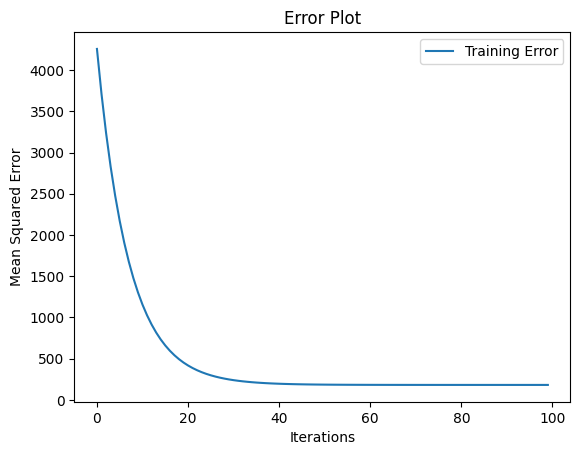

Mean squared error: 491.80941994778624


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

    
X, y = make_regression(n_samples=100, n_features=3, noise=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
n_samples, n_features = np.shape(X)
model = LinearRegression(n_iterations=100)
model.fit(X_train, y_train)

# Training error plot
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("Mean squared error: %s" % (mse))
y_pred_line = model.predict(X)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


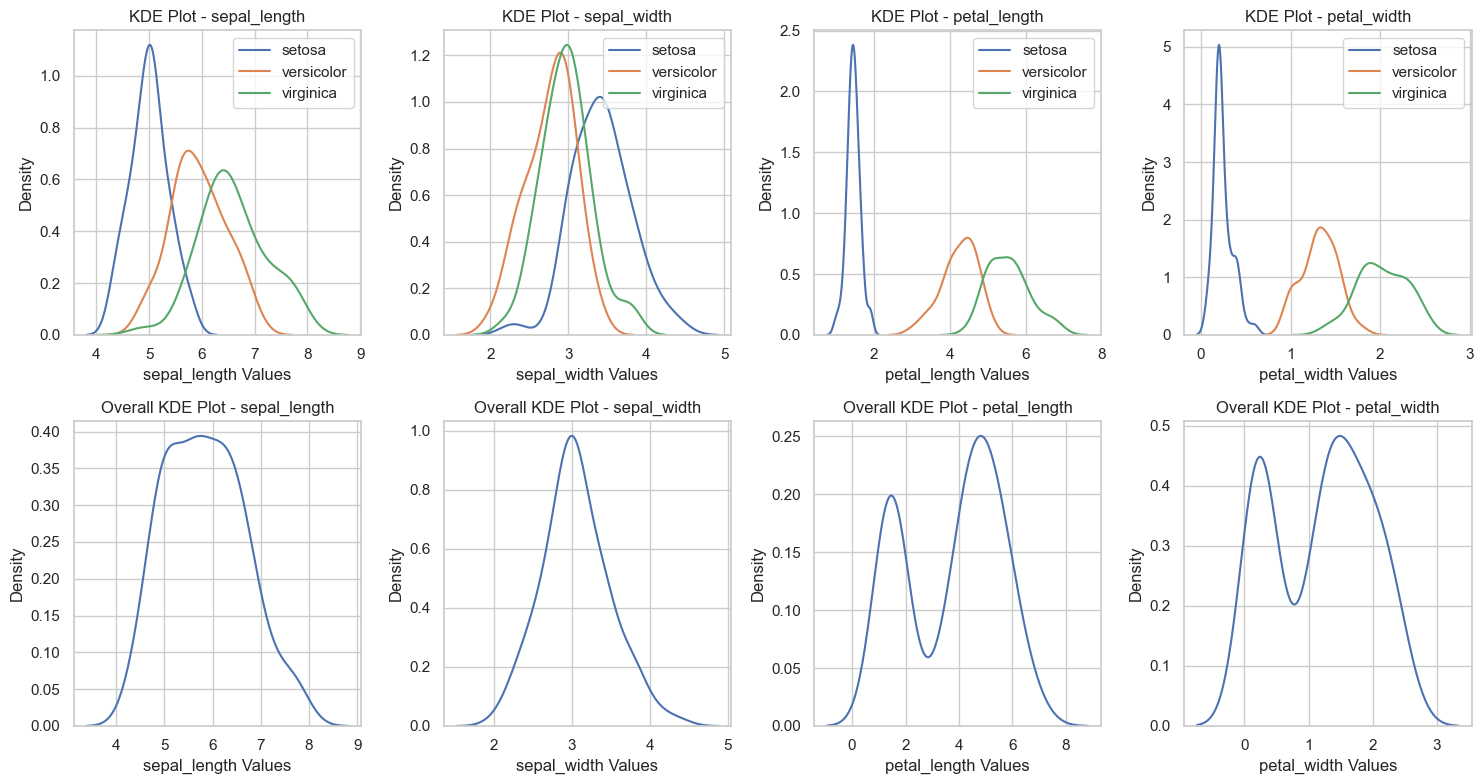

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
data = sns.load_dataset('iris')

# Set style
sns.set(style="whitegrid")

# Create separate KDE plots for each feature with and without subgrouping by species
features = data.columns[:-1]  # Exclude the 'species' column
num_features = len(features)

fig, axes = plt.subplots(nrows=2, ncols=num_features, figsize=(15, 8))

# First row: KDE plots for each feature grouped by species
for i, feature in enumerate(features):
    for species in data['species'].unique():
        subset = data[data['species'] == species]
        display(subset)
        sns.kdeplot(subset[feature], ax=axes[0, i], label=species)

    axes[0, i].set_title(f'KDE Plot - {feature}')
    axes[0, i].set_xlabel(f'{feature} Values')
    axes[0, i].set_ylabel('Density')
    axes[0, i].legend()

# Second row: Overall KDE plots for each feature without subgrouping by species
for i, feature in enumerate(features):
    sns.kdeplot(data[feature], ax=axes[1, i])
    axes[1, i].set_title(f'Overall KDE Plot - {feature}')
    axes[1, i].set_xlabel(f'{feature} Values')
    axes[1, i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


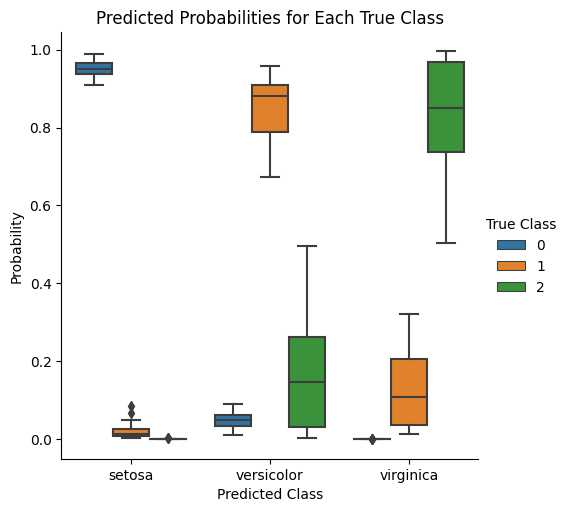

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get predicted probabilities for each class
probs = log_reg.predict_proba(X_test)

# Create a DataFrame for probabilities
probs_df = pd.DataFrame(probs, columns=iris.target_names)

# Separate probabilities into three subsets based on true class labels
subset_probs = []
for class_label in range(3):
    subset_probs.append(probs_df[y_test == class_label])

# Combine all subsets into one DataFrame
combined_df = pd.concat(subset_probs)

# Add a column for the true class labels
true_labels = []
for class_label, subset in enumerate(subset_probs):
    true_labels.extend([class_label] * len(subset))

combined_df['True Class'] = true_labels

# Melt the DataFrame for plotting
melted_df = pd.melt(combined_df, id_vars=['True Class'], var_name='Predicted Class', value_name='Probability')

# Create a box plot with seaborn's catplot
sns.catplot(x='Predicted Class', y='Probability', hue='True Class', kind='box', data=melted_df)
plt.title('Predicted Probabilities for Each True Class')
plt.show()


Accuracy: 0.8222222222222222


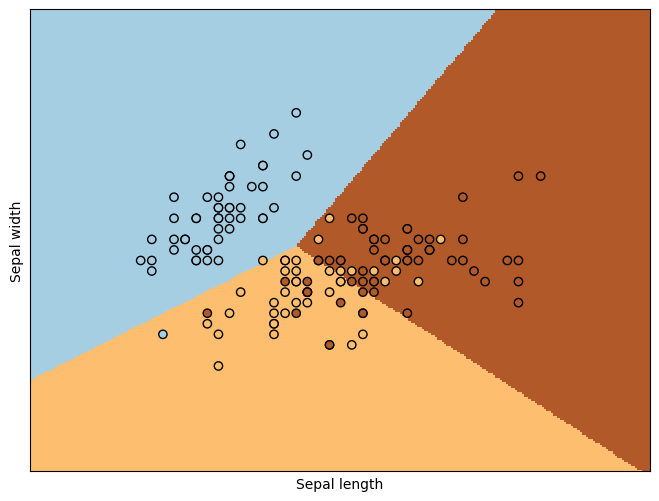

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=3, n_clusters_per_class=1, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit multinomial logistic regression model using statsmodels
model = MNLogit(y_train, sm.add_constant(X_train_scaled))
results = model.fit_regularized(method='elastic_net', alpha=1.0, L1_wt=0.0)
result = model.fit()

# Predict and evaluate the model
y_pred_train = np.argmax(result.predict(), axis=1)
y_pred_test = np.argmax(result.predict(sm.add_constant(X_test_scaled)), axis=1)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Plot the Lasso regularization path
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X_train_scaled, y_train)

coefs = clf.coef_.ravel()

plt.figure(figsize=(10, 6))
plt.plot(coefs)
plt.title('Lasso Regularization Path')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.show()
